In [ ]:
# LinkNet with ResNet34 for multiclass semantic segmentation
!pip install tensorflow==2.1.0

In [2]:
!pip install segmentation-models

In [3]:
# mount google drive here
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install 'h5py==2.10.0' --force-reinstall


In [4]:
# Fetch the training, validation and testing dataset
import os
import numpy as np

dataPath  = '/content/drive/My Drive/Underwater_Segmentation_Research/Weights/PSPNET'
d = '/content/drive/My Drive/Underwater_Segmentation_Research/Data'

trainPath       =  dataPath + '/Train'
testPath        =  dataPath + '/Test'
valPath         =  d + '/Validate'

trainImgsFile   = 'trainingDataImgs.npy'
trainLabelsFile = 'trainingDataLabels.npy'

testImgsFile    = 'testingDataImgs.npy'
testLabelsFile  = 'testingDataLabels.npy'

valImgsFile     = 'validationDataImgs.npy'
valLabelsFile   = 'validationDataLabels.npy'

def getData(path,fileName):
  return np.load(path + "/" + fileName)

'''
trainImgs   = getData(dataPath, trainImgsFile)
trainLabels = getData(dataPath, trainLabelsFile)

valImgs    = getData(dataPath, valImgsFile)
valLabels  = getData(dataPath, valLabelsFile)

print("Got train and validation data")
print(trainImgs.shape, valImgs.shape)
print(trainLabels.shape, valLabels.shape)
'''


'\ntrainImgs   = getData(dataPath, trainImgsFile)\ntrainLabels = getData(dataPath, trainLabelsFile)\n\nvalImgs    = getData(dataPath, valImgsFile)\nvalLabels  = getData(dataPath, valLabelsFile)\n\nprint("Got train and validation data")\nprint(trainImgs.shape, valImgs.shape)\nprint(trainLabels.shape, valLabels.shape)\n'

In [ ]:
# Create the model (without pre-trained ImageNet weights)
import os
import numpy as np
import tensorflow as tf
import segmentation_models as sm

# create the model
model = sm.PSPNet('vgg16', input_shape=(480, 480, 1), encoder_weights=None, classes=12, activation='softmax')
model.summary()


In [8]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

In [9]:
import tensorflow as tf
LOSS=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile('Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', UpdatedMeanIoU(num_classes=12)])

In [ ]:
# Setup training parameters
BATCH = 16
EPOCHS = 30

# early stopping callback. It stops training when the loss does not change for 3 consecutive epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
# Start training the model
history = model.fit(trainImgs, trainLabels, epochs=EPOCHS, batch_size=BATCH, validation_data=(valImgs, valLabels))

dict_keys(['loss', 'accuracy', 'updated_mean_io_u', 'val_loss', 'val_accuracy', 'val_updated_mean_io_u'])


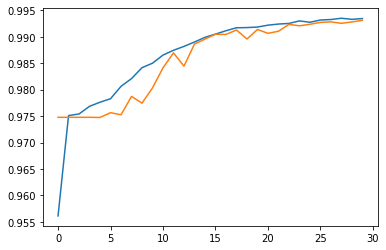

In [7]:
#  Plot the results
print(history.history.keys())

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

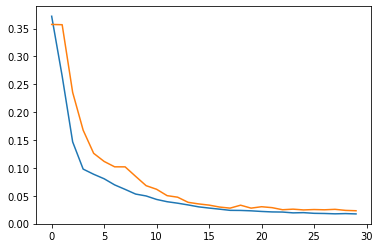

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

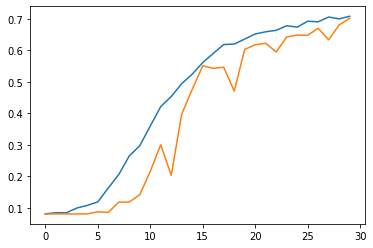

In [9]:
plt.plot(history.history['updated_mean_io_u'])
plt.plot(history.history['val_updated_mean_io_u'])

In [10]:
# get the testdata
testImgs   = getData(dataPath, testImgsFile)
testLabels = getData(dataPath, testLabelsFile)
print(testImgs.shape, testLabels.shape)

(617, 480, 480, 1) (617, 480, 480, 1)


In [13]:
model.evaluate(testImgs, testLabels)

617/617 [==============================] - 1489s 2s/sample - loss: 0.0195 - accuracy: 0.9934 - updated_mean_io_u_1: 0.7131


[0.019459603469052036, 0.9933696, 0.7131087]

In [11]:
# save the model weights
weightFileName = "PSPVggNet16_30e_16b.h5"
weightPath = '/content/drive/My Drive/Underwater_Segmentation_Research/Weights/PSPNET'
#model.save_weights(weightPath + "/" + weightFileName)


In [12]:
model.load_weights(weightPath + "/" + weightFileName)
#model.evaluate(testImgs, testLabels)

In [ ]:
modelFileName = "PSPVggNet16_30e_16b"
modelPath     = '/content/drive/My Drive/Underwater_Segmentation_Research/Models/PSPNET'
model.save(modelPath + "/" + modelFileName)

In [ ]:
# Check the GPU configuration
!nvidia-smi

In [ ]:
y_preds = ((model.predict(testImgs)) >= 0.5).astype(np.uint8)
#y_preds = (y_preds >= 0.5).astype(np.uint8)

In [ ]:
# Compute mean of per-class IOU throughout the test images
num_classes=12
m = UpdatedMeanIoU(num_classes=12)
m.update_state(testLabels, y_preds)

print(f'Overall mean IOU is : {m.result().numpy()}')

# Values is the confusion matrix
values = np.array(m.get_weights()).reshape(num_classes, num_classes)

In [ ]:
# compute the mean per-class IOU
numClasses = 12

classIOU = []

for i in range(numClasses):
  rowSum = np.sum(values[i,:])
  colSum = np.sum(values[:,i])
  denom = rowSum + colSum - values[i,i]
  iou = values[i,i]/denom
  classIOU.append(iou)

print(classIOU)
perClassIoU = np.array(classIOU)
print(np.mean(perClassIoU))


In [ ]:
yPreds = tf.argmax(ypreds, axis=-1)
yPreds = yPreds.numpy()

In [ ]:
import matplotlib.pyplot as plt
i = 0
plt.imshow(yPreds[i])
plt.show()

print(np.unique(yPreds[i,:,:]))

plt.imshow(testLabels[i,:,:,0])
plt.show()

print(np.unique(testLabels[i,:,:,0]))

t = np.linspace(0,11,num=12)
plt.plot(t, perClassIoU)
plt.show()